In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
#from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
#import plotly.express as px
import random
#from keras.losses import SparseCategoricalCrossentropy
from collections import Counter
import seaborn as sns
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
#from keras import Layers
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import gc
from typing import List, Tuple


2024-12-08 20:02:20.658464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 20:02:20.695020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 20:02:20.705176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 20:02:20.742719: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1733684543.705800   28338 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733684543.866105   28338 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733684543.866173   28338 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
import os
from typing import List, Tuple
import numpy as np
from PIL import Image

def fetch_and_preprocess_images(
    data_folder: str, 
    target_size: Tuple[int, int] = (30, 30)
) -> Tuple[List[Tuple], List[Tuple], List[Tuple]]:
    """
    Load and preprocess images from dataset with resizing and normalized coordinates.
    
    Args:
        data_folder (str): Root directory containing train/test/valid splits
        target_size (Tuple[int, int]): Desired image size (default: 30x30)
    
    Returns:
        Tuple of lists: (train_data, test_data, valid_data)
        Each list contains tuples of (image_array, class_ids, normalized_bboxes)
    """
    train_data, test_data, valid_data = [], [], []
    
    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }
    
    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")
        
        # Use list comprehension for more efficient file processing
        image_names = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        for image_name in image_names:
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)
            
            # Skip if label file is missing
            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue
            
            # Open and resize image
            with Image.open(image_path).convert("RGB") as img:
                original_width, original_height = img.size
                img_resized = img.resize(target_size, Image.LANCZOS)
                img_array = np.array(img_resized)
            
            class_ids = []
            normalized_bboxes = []
            
            with open(label_path, "r") as label_file:
                for line in label_file:
                    parts = line.strip().split()
                    
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])
                    
                    # Maintain normalized coordinates after resizing
                    # Scale factor will be target_size / original_size
                    width_scale = target_size[0] / original_width
                    height_scale = target_size[1] / original_height
                    
                    # Adjust center coordinates and dimensions
                    new_x_center = x_center * width_scale
                    new_y_center = y_center * height_scale
                    new_width = width * width_scale
                    new_height = height * height_scale
                    
                    class_ids.append(class_id)
                    normalized_bboxes.append([
                        new_x_center, 
                        new_y_center, 
                        new_width, 
                        new_height
                    ])
            
            # Store data in appropriate split
            split_data = {
                "train": train_data,
                "test": test_data,
                "valid": valid_data
            }
            split_data[split_name].append((img_array, class_ids, normalized_bboxes))
    
    return train_data, test_data, valid_data

In [4]:
# Example usage
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_and_preprocess_images(data_folder)

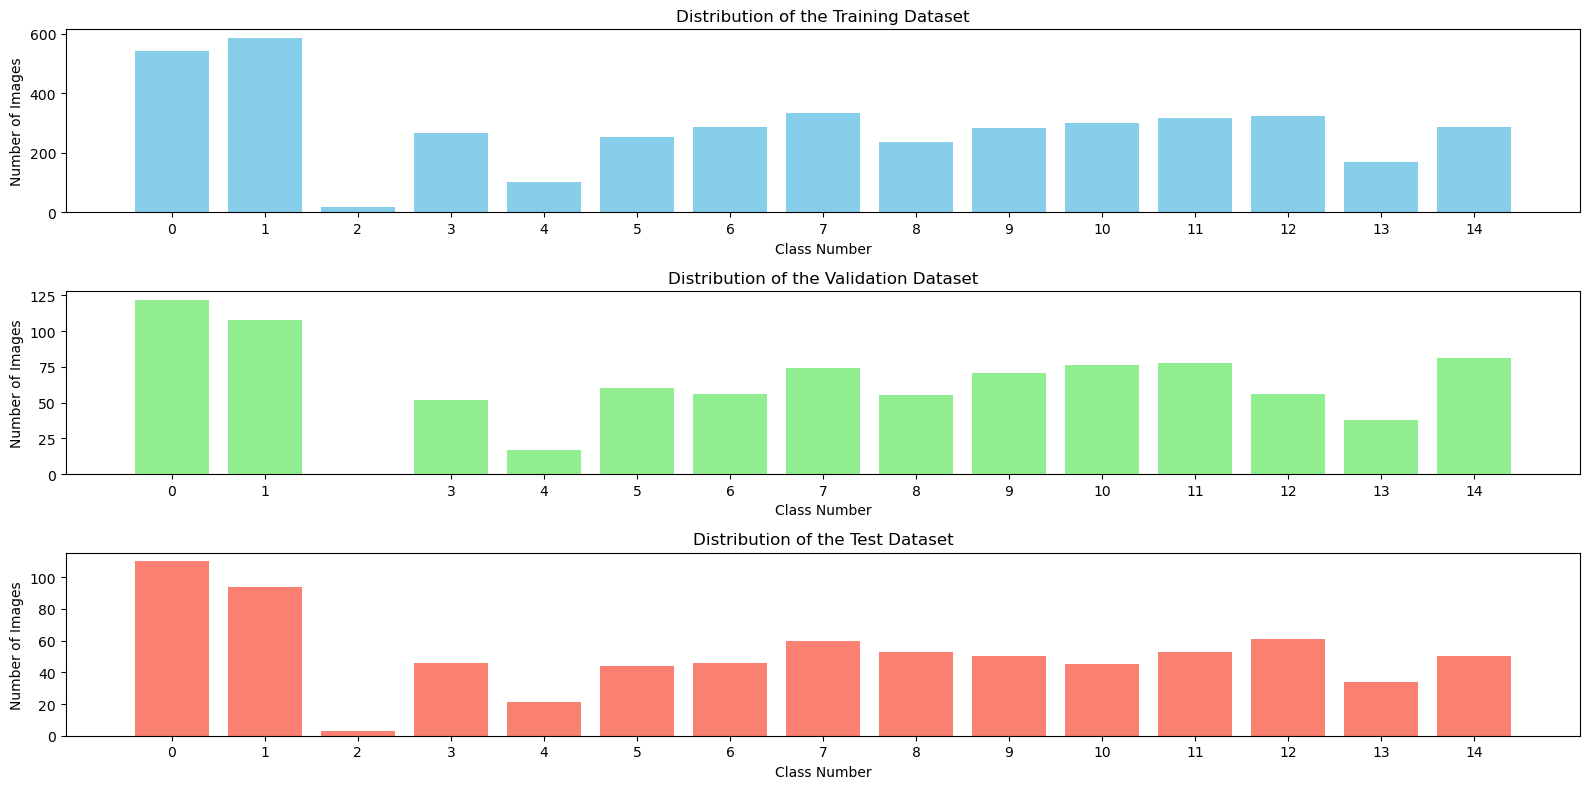

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the number of samples per class in each dataset
train_class_counts = Counter(class_id for _, class_ids, _ in train_data for class_id in class_ids)
valid_class_counts = Counter(class_id for _, class_ids, _ in valid_data for class_id in class_ids)
test_class_counts = Counter(class_id for _, class_ids, _ in test_data for class_id in class_ids)

# Sort the counts for consistent visualization
train_classes, train_num_of_samples = zip(*sorted(train_class_counts.items()))
valid_classes, valid_num_of_samples = zip(*sorted(valid_class_counts.items()))
test_classes, test_num_of_samples = zip(*sorted(test_class_counts.items()))

# Plot the distributions for all splits
plt.figure(figsize=(16, 8))

# Training Dataset
plt.subplot(3, 1, 1)
plt.bar(train_classes, train_num_of_samples, color='skyblue')
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(train_classes)

# Validation Dataset
plt.subplot(3, 1, 2)
plt.bar(valid_classes, valid_num_of_samples, color='lightgreen')
plt.title("Distribution of the Validation Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(valid_classes)

# Test Dataset
plt.subplot(3, 1, 3)
plt.bar(test_classes, test_num_of_samples, color='salmon')
plt.title("Distribution of the Test Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(test_classes)

# Show the combined plot
plt.tight_layout()
plt.show()


In [16]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract training labels and class indices
training_labels = []
for class_id, count in Counter({1: 585, 0: 542, 7: 334, 12: 323, 11: 318, 10: 301, 6: 285, 
                                 14: 285, 9: 283, 3: 267, 5: 252, 8: 235, 13: 168, 4: 101, 2: 19}).items():
    training_labels.extend([class_id] * count)

# Calculate class weights
classes = np.unique(training_labels)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=training_labels)

# Convert to a dictionary for Keras
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.5286592865928659, 1: 0.4898005698005698, 2: 15.080701754385965, 3: 1.0731585518102371, 4: 2.836963696369637, 5: 1.137037037037037, 6: 1.0053801169590644, 7: 0.8578842315369262, 8: 1.219290780141844, 9: 1.012485276796231, 10: 0.951937984496124, 11: 0.9010482180293501, 12: 0.8871001031991744, 13: 1.7055555555555555, 14: 1.0053801169590644}


In [21]:
def prepare_training_data(train_data, max_objects=10, num_classes=15):
    """
    Prepare training data with handling for variable number of objects per image.
    
    Args:
        train_data (List[Tuple]): List of (image, class_ids, bounding_boxes)
        max_objects (int): Maximum number of objects to consider per image
        num_classes (int): Number of classification classes
    
    Returns:
        Tuple: (processed_features, processed_labels, processed_bboxes)
    """
    # Separate components
    train_data_features, train_data_labels, train_data_bounding_boxes = zip(*train_data)
    
    # Normalize and reshape features
    train_data_features = np.array(train_data_features).astype(np.float32) / 255.0
    train_data_features = train_data_features.reshape(-1, 30, 30, 3)
    
    # Prepare labels with padding
    processed_labels = np.zeros((len(train_data), max_objects), dtype=np.int32)
    #processed_labels = processed_labels.reshape((-1, 15))

    processed_bboxes = np.zeros((len(train_data), max_objects, 4), dtype=np.float32)

    
    # One-hot encode the labels
    processed_labels_onehot = tf.keras.utils.to_categorical(
        processed_labels, 
        num_classes=num_classes
    )
    
    return {
        'features': train_data_features,
        'labels': processed_labels_onehot.reshape((-1, 15)),
        'bboxes': processed_bboxes,
    }


In [22]:
processed_data = prepare_training_data(train_data)

# In your model or loss function
training_data_features = processed_data['features']
training_data_labels = processed_data['labels']
training_data_bounding_boxes = processed_data['bboxes']
#valid_mask = processed_data['valid_mask']

In [23]:
training_data_labels.shape

(35300, 15)

In [24]:
# Verify normalization
print("Feature range:", training_data_features.min(), training_data_features.max())
print("Number of augmented samples:", len(training_data_features))

Feature range: 0.0 1.0
Number of augmented samples: 3530


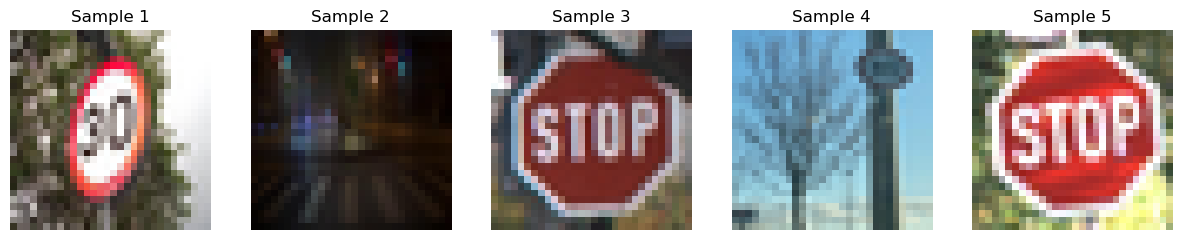

In [25]:
import matplotlib.pyplot as plt
import random

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    random_idx = random.randint(0, len(training_data_features) - 1)
    img = training_data_features[random_idx]

    # Ensure proper scaling to 0-255
    img = (img * 255).astype(np.uint8)

    axs[i].imshow(img, cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Sample {i+1}")

plt.show()


In [26]:
training_data_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [27]:
import tensorflow as tf
from keras.layers import (
    Conv2D, MaxPool2D, Dropout, Flatten, 
    Dense, Input, Concatenate
)
from keras.models import Model
from keras.regularizers import l2
from keras.initializers import HeNormal, RandomNormal

def create_multi_task_cnn(num_classes=15, num_bbox_coords=4):
    """
    Create a multi-task Convolutional Neural Network for 
    simultaneous classification and bounding box regression.
    
    Args:
        num_classes (int): Number of classification classes
        num_bbox_coords (int): Number of bounding box coordinates (typically 4)
    
    Returns:
        tf.keras.Model: Compiled multi-task model
    """
    # Input layer
    input_layer = Input(shape=(30, 30, 3), name="input")
    
    # Convolutional Block 1
    x = Conv2D(32, (5,5), padding="same", activation='relu', 
               kernel_initializer=HeNormal())(input_layer)
    x = MaxPool2D((2, 2), padding="same")(x)
    
    # Convolutional Block 2
    x = Conv2D(64, (5,5), padding="same", activation='relu', 
               kernel_initializer=HeNormal())(x)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Dropout(0.15)(x)
    
    # Convolutional Block 3
    x = Conv2D(128, (3,3), padding="same", activation='relu', 
               kernel_initializer=HeNormal())(x)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Dropout(0.2)(x)
    
    # Convolutional Block 4
    x = Conv2D(256, (3,3), padding="same", activation='relu', 
               kernel_initializer=HeNormal())(x)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Dropout(0.3)(x)
    
    # Flatten layer
    x = Flatten()(x)
    
    # Shared Dense Layer
    shared_dense = Dense(512, activation='relu', 
                         kernel_regularizer=l2(0.001))(x)
    shared_dense = Dropout(0.25)(shared_dense)
    
    # Classification Head
    classification_head = Dense(
        num_classes, 
        activation='softmax', 
        name='classification_output',
        kernel_regularizer=l2(0.0001)
    )(shared_dense)
    
    # Regression Head (Bounding Box)
    regression_head = Dense(
        num_bbox_coords, 
        activation='linear', 
        name='regression_output',
        kernel_initializer=RandomNormal(seed=43),
        kernel_regularizer=l2(0.1)
    )(shared_dense)
    
    # Create Model with Multiple Outputs
    model = Model(
        inputs=input_layer, 
        outputs=[classification_head, regression_head]
    )
    
    # Compile the model with appropriate losses
    model.compile(
        optimizer='adam',
        loss={
            'classification_output': 'categorical_crossentropy',
            'regression_output': 'mse'  # Mean Squared Error for bounding box regression
        },
        loss_weights={
            'classification_output': 1.0,  # Adjust these weights as needed
            'regression_output': 1.0
        },
        metrics={
            'classification_output': 'accuracy',
            'regression_output': 'mae'  # Mean Absolute Error
        }
    )
    
    return model

# Example usage
# model = create_multi_task_cnn(num_classes=15, num_bbox_coords=4)
# model.summary()

In [28]:
model = create_multi_task_cnn(num_classes=15, num_bbox_coords=4)


I0000 00:00:1733685080.957317   28338 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733685080.957488   28338 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733685080.957534   28338 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733685081.186925   28338 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733685081.187023   28338 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-08

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 30, 30, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,432 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 15, 15,    │     51,264 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 8, 64)  │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 4, 4, 128) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 256) │    295,168 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 2, 2, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2, 2, 256) │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    524,800 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 15)        │      7,695 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 4)         │      2,052 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 957,267 (3.65 MB)

 Trainable params: 957,267 (3.65 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
processed_validation_data = prepare_training_data(valid_data)

# In your model or loss function
validation_data_features = processed_data['features']
validation_data_labels = processed_data['labels']
validation_data_bounding_boxes = processed_data['bboxes']
#valid_mask = processed_data['valid_mask']

In [38]:
validation_data_bounding_boxes.shape

(3530, 10, 4)

In [39]:
# One-hot encode the labels with the correct number of classes
training_data_labels = tf.keras.utils.to_categorical(
    training_data_labels, 
    num_classes=15  # Adjust to match your model's output layer
)
# Ensure target shape is (batch_size, 15)
validation_data_labels = tf.keras.utils.to_categorical(
    validation_data_labels, 
    num_classes=15  # Same number of classes
)


In [40]:

# Now train the model
trafficSignNetwork = model.fit(
    processed_data['features'], 
    {
        'classification_output': processed_data['labels'],
        'regression_output': processed_data['bboxes']
    },
    validation_data=(
        processed_validation_data['features'],
        {
            'classification_output': processed_validation_data['labels'],
            'regression_output': processed_validation_data['bboxes']
        }
    ),
    epochs=30, 
    batch_size=32
)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 3530
'y' sizes: 35300, 3530


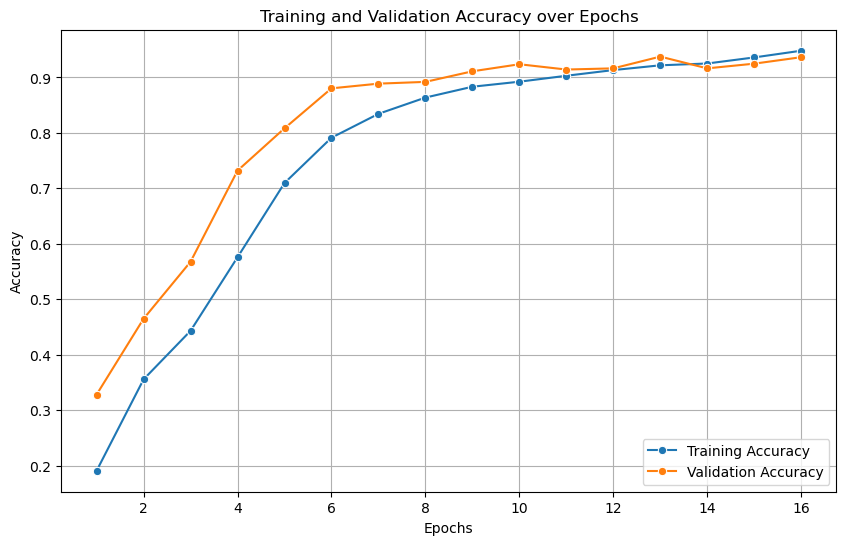

In [36]:
import seaborn as sns
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(range(1, len(trafficSignNetwork.history['accuracy']) + 1)),
             y=trafficSignNetwork.history['accuracy'],
             marker='o', label='Training Accuracy')

sns.lineplot(x=list(range(1, len(trafficSignNetwork.history['val_accuracy']) + 1)),
             y=trafficSignNetwork.history['val_accuracy'],
             marker='o', label='Validation Accuracy')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

In [37]:
test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features)
test_data_labels = np.array(test_data_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


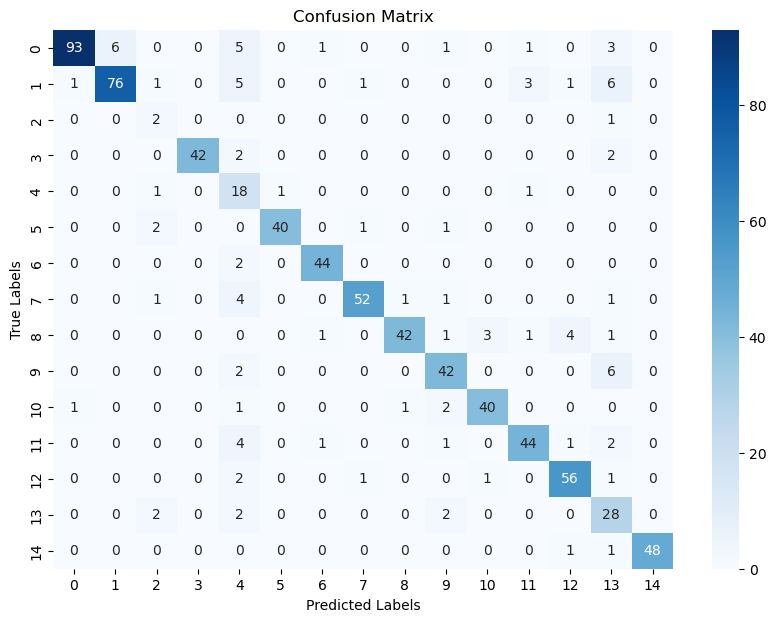

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels on the test data
test_predictions = cnnModel.predict(test_data_features)
# Convert predictions from probabilities to class labels (use argmax to get the index of the highest probability)
test_predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [39]:
from sklearn.metrics import classification_report
print(classification_report(test_data_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       110
           1       0.93      0.81      0.86        94
           2       0.22      0.67      0.33         3
           3       1.00      0.91      0.95        46
           4       0.38      0.86      0.53        21
           5       0.98      0.91      0.94        44
           6       0.94      0.96      0.95        46
           7       0.95      0.87      0.90        60
           8       0.95      0.79      0.87        53
           9       0.82      0.84      0.83        50
          10       0.91      0.89      0.90        45
          11       0.88      0.83      0.85        53
          12       0.89      0.92      0.90        61
          13       0.54      0.82      0.65        34
          14       1.00      0.96      0.98        50

    accuracy                           0.87       770
   macro avg       0.82      0.86      0.82       770
weighted avg       0.90   

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for each class
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  # sum of the column - TP
    fn = cm[i, :].sum() - tp  # sum of the row - TP
    tn = cm.sum() - (tp + fp + fn)
    
    # Calculate Precision, Recall, F1-Score, and Accuracy
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print()


Class 0:
True Positive (TP): 100
False Positive (FP): 11
False Negative (FN): 10
True Negative (TN): 649
Precision: 0.9009
Recall: 0.9091
F1-Score: 0.9050
Accuracy: 0.9727

Class 1:
True Positive (TP): 76
False Positive (FP): 9
False Negative (FN): 18
True Negative (TN): 667
Precision: 0.8941
Recall: 0.8085
F1-Score: 0.8492
Accuracy: 0.9649

Class 2:
True Positive (TP): 3
False Positive (FP): 8
False Negative (FN): 0
True Negative (TN): 759
Precision: 0.2727
Recall: 1.0000
F1-Score: 0.4286
Accuracy: 0.9896

Class 3:
True Positive (TP): 38
False Positive (FP): 2
False Negative (FN): 8
True Negative (TN): 722
Precision: 0.9500
Recall: 0.8261
F1-Score: 0.8837
Accuracy: 0.9870

Class 4:
True Positive (TP): 18
False Positive (FP): 31
False Negative (FN): 3
True Negative (TN): 718
Precision: 0.3673
Recall: 0.8571
F1-Score: 0.5143
Accuracy: 0.9558

Class 5:
True Positive (TP): 38
False Positive (FP): 2
False Negative (FN): 6
True Negative (TN): 724
Precision: 0.9500
Recall: 0.8636
F1-Score: 0

In [40]:
cnnModel.save("models/model_v4.keras")
